# Mauna Loa CO2

In this Notebook (as a lot of other ones) we'll consider modelling the Mauna Loa CO2 dataset using structural timeseries in numpyro. As always, we begin importing the data

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

datas = fetch_openml(data_id=41187, as_frame=True).frame
datas.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


Let's construct a proper date time value and set as index

In [2]:
datas.index = datas.apply(lambda u: pd.Timestamp(year=u["year"], month=u["month"], day=u["day"]), axis=1)

datas.head()

,year,month,day,weight,flag,station,co2
1958-03-29,1958,3,29,4,0,MLO,316.1
1958-04-05,1958,4,5,6,0,MLO,317.3
1958-04-12,1958,4,12,4,0,MLO,317.6
1958-04-19,1958,4,19,6,0,MLO,317.5
1958-04-26,1958,4,26,2,0,MLO,316.4


Let's only select the CO2 column and resample to monthly

Text(0.5, 1.0, 'CO2 at Mauna Loa')

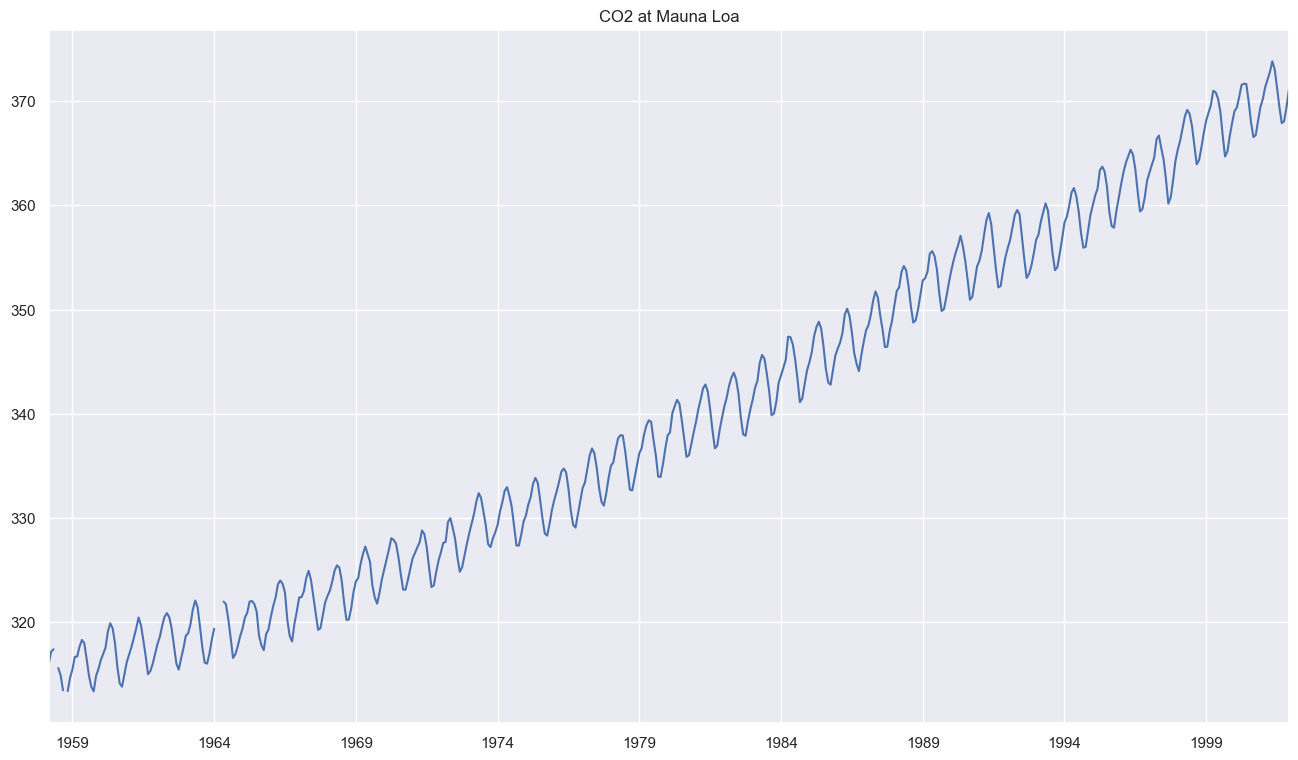

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

plt.rcParams["figure.figsize"] = (16, 9)

co2 = datas["co2"].resample("ME").mean()

fig, ax = plt.subplots()
co2.plot(ax=ax)

ax.set_title("CO2 at Mauna Loa")

We clearly see that there is both a trend and seasonality component in the data. The model seems to be additive as it doesn't grow/shrink with time. The seasonality component seems to be constant. Let's set up our model

In [4]:
from numpyro.distributions import HalfNormal, Normal, HalfCauchy, ZeroSumNormal
import numpyro
from numpyro_sts import periodic, RandomWalk
import numpy as np


numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")


def model(n: int, y: np.ndarray = None, mask: bool = True, num_seasons: int = 12, future: int = 0):
    # level component
    with numpyro.handlers.scope(prefix="level"):
        std = numpyro.sample("std", HalfNormal(scale=100.0))
        drift = numpyro.sample("drift", HalfNormal())

        x_0_loc = numpyro.sample("x_0_loc", Normal(scale=1000.0))
        x_0 = x_0_loc + numpyro.sample("x_0", Normal())

        level_model = RandomWalk(n, std, x_0, drift=drift)
        level = numpyro.sample("x", level_model)

        if future > 0:
            future_level = numpyro.sample("x_future", level_model.predict(future, level[-1]))

    # seasonality
    with numpyro.handlers.scope(prefix="seasonality"):
        x_0 = numpyro.sample("x_0", ZeroSumNormal(scale=10.0, event_shape=(num_seasons,)))[:-1]

        seasonality_model = periodic.TimeSeasonal(n, num_seasons, 0.0, x_0)
        seasonality = numpyro.deterministic("x", seasonality_model.deterministic())

        if future > 0:
            future_seasonality = numpyro.deterministic(
                "x_future", seasonality_model.predict(future, seasonality[-1]).deterministic()
            )

    # observable
    std = numpyro.sample("std", HalfCauchy())
    loc = level[..., 0] + seasonality[..., 0]

    with numpyro.handlers.mask(mask=mask):
        y_ = numpyro.sample("y", Normal(loc, std), obs=y)

    if future > 0:
        loc_future = future_level[..., 0] + future_seasonality[..., 0]
        y_future = numpyro.sample("y_future", Normal(loc_future, std))

    return

Since we have a fully probabilistic model, let's sample from the model and see it's outputs

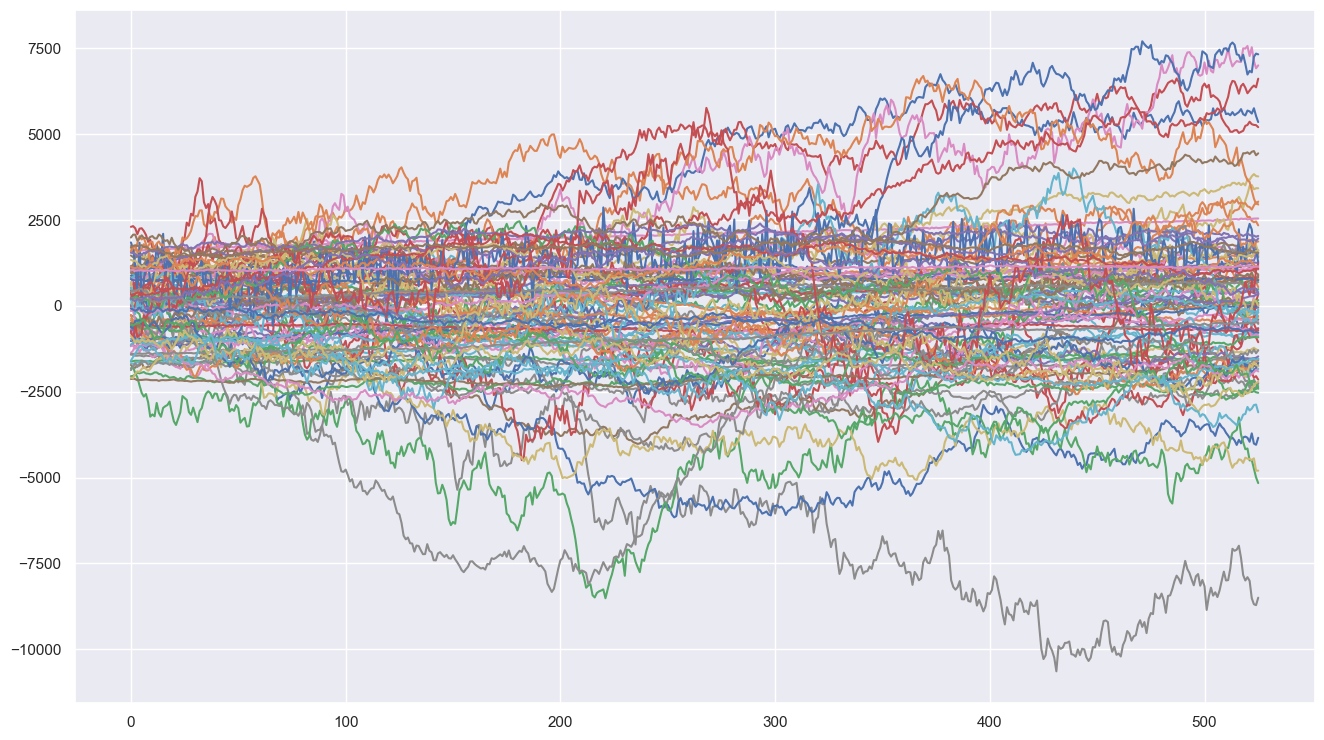

In [5]:
from numpyro.infer import Predictive
import jax.random as jrnd

predictive = Predictive(model, num_samples=100)
key = jrnd.PRNGKey(0)

samples = predictive(key, n=co2.shape[0])

fig, ax = plt.subplots()
ax.plot(samples["y"].swapaxes(0, -1))

Alright, let's perform some inference after splitting the data into a 85% and 15% train-test split

In [6]:
from sklearn.model_selection import train_test_split
from numpyro.infer import NUTS, MCMC

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5_000, num_samples=1_000, num_chains=4)

train, test = train_test_split(co2.values, shuffle=False, train_size=0.85)

mcmc.run(key, n=train.shape[0], y=train, mask=np.isfinite(train))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Let's look at the summary

In [7]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
        level/drift      0.10      0.01      0.10      0.09      0.12   8355.65      1.00
          level/std      0.23      0.02      0.23      0.20      0.26    435.71      1.02
       level/x[0,0]    314.67      0.14    314.67    314.44    314.90   4265.23      1.00
       level/x[1,0]    314.69      0.13    314.69    314.48    314.88   5730.38      1.00
       level/x[2,0]    314.65      0.13    314.65    314.45    314.88   3006.54      1.00
       level/x[3,0]    314.90      0.19    314.90    314.59    315.23   3472.45      1.00
       level/x[4,0]    315.15      0.13    315.15    314.93    315.37   1953.59      1.00
       level/x[5,0]    315.95      0.13    315.96    315.73    316.18   1619.89      1.00
       level/x[6,0]    316.21      0.15    316.21    315.97    316.44   1346.99      1.00
       level/x[7,0]    315.91      0.19    315.91    315.60    316.21   4914.64      1.00
       le

The summary looks good - let's predict!

In [8]:
samples = mcmc.get_samples()

predictive = Predictive(model, posterior_samples=samples)
predictions = predictive(key, n=train.shape[0], y=train, future=test.shape[0])

predictions.keys()

dict_keys(['level/x_future', 'seasonality/x', 'seasonality/x_future', 'y', 'y_future'])

And plot

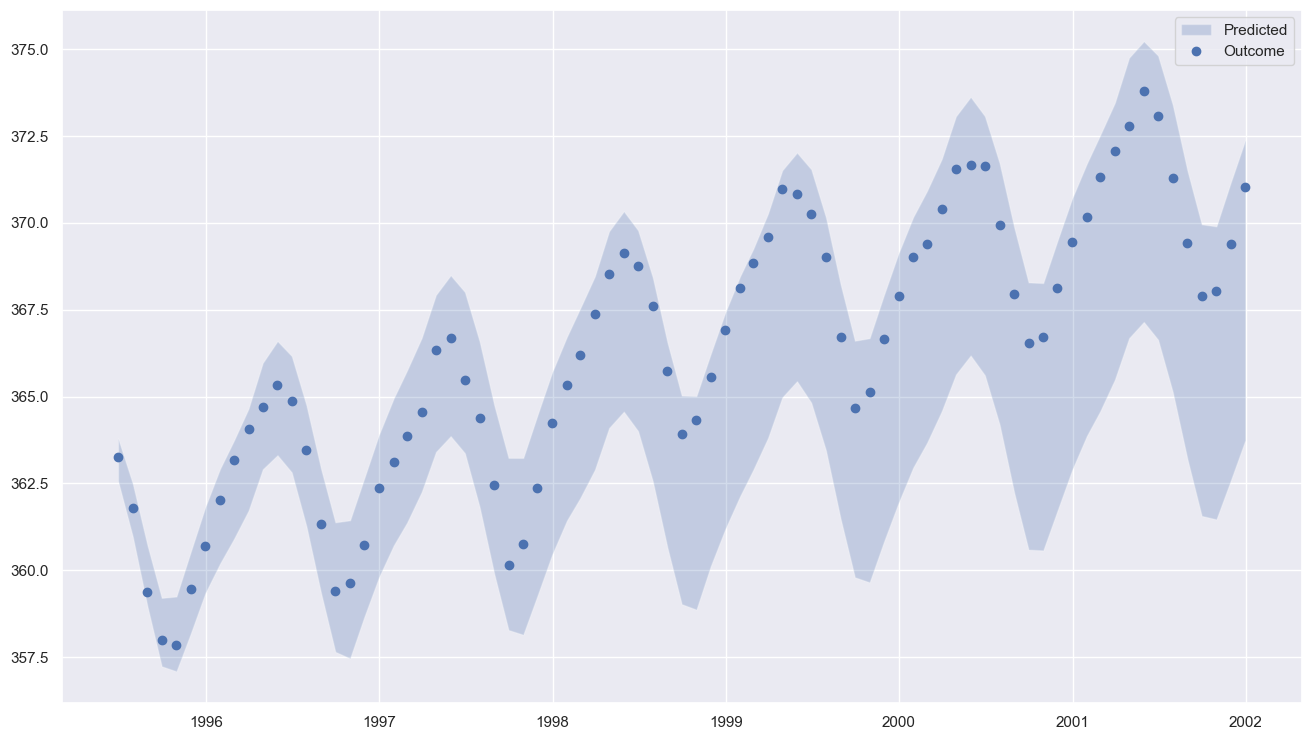

In [10]:
import numpy as np

low, high = np.quantile(predictions["y_future"], [0.025, 0.975], axis=0)

inds = np.arange(train.shape[0], test.shape[0] + train.shape[0])

fig, ax = plt.subplots()

future_dates = co2.index[inds]

ax.fill_between(future_dates, low, high, alpha=0.25, label="Predicted")
ax.plot(future_dates, test, "o", label="Outcome")

ax.legend()

Alright, predictions look pretty good! We capture all of the future observations. However, it seems as though the outcomes lie in the right tail of the predictive distributions starting from 1998, indicating that the drift component increases over time. As such, it might be more reasonable to model the level component as a local linear trend model to capture time varying trends. It is however pretty ambitious to try and predict a monthly series so far into the future. So, let's leave our analysis there!